<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Features-to-add" data-toc-modified-id="Features-to-add-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Features to add</a></span></li></ul></div>

Here I am merging tables onto the main table, transfers.

## Features to add

Adding for sure:

- Prescriptions, which is ready

- Admissions: check ppoint, non-white?, marital status??, medicaid, language?

- Patients: Age and gender

- POE: Many categories (order type), but decent. 


Maybe adding in the future:

- Procedures by ICD code, could be interesting but lots of features

- Lab events: A LOT of features, although you can just add flag (associated with storetime) and priority (associated with charttime of test (frequency encoding?)

- OMR: Blood pressure, weight... Interesting but probably there will be many missing values and will be hard to incorporate into dataframe

- hcpcsevents: A LOT of features

- Microbiology events: A LOT of features (no outcomes clear, although there are comments of test)


<br><br>

Some questions: 

Should I increase the granularity of the prescriptions (go down to level 2, 3 or 4). That would add between 1K and 5K features

Can I leave duration of transfer in datetime or should I categorise it/bin it?
bin

Should I bin age or can be quantitative?
Bin it (maybe check before when it's quantitative)

Is it okay adding POE? Should I stop there or add also the other tables? It would mean lots of features. 

Should I add measures such as blood pressure and weight even if values will be missing in many rows? And again do I have to bin?
Leave it for now and maybe with the PCA it tells you something. Maybe you see that could be good to include

Focus on not adding any extra features but focus on step 1 (do PCA, fit models and decide whether to add more features or not)

Step 1
For small dataset
logistic regression SVM, decision tree and random forest, naive bayes
Group the classes before fitting the model
PCA to see if I can compress the model as it is right now
See if by going up on the number of features you are getting any gain
How many orders for now and that's it

Step 2
For large dataset

For dataset try to make bins if possible, 5-10

Distribution is skewed. But after we have converted (the class) into binary, the problem we have is bias (the model is biased).

In [39]:
import numpy as np
import pandas as pd
import copy
import nachopy
import importlib
import pickle
import sklearn

%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.dpi'] = 500
plt.style.use('ggplot')
import matplotlib as mpl
import seaborn as sns
importlib.reload(nachopy)

<module 'nachopy' from 'C:\\Users\\Nacho\\Capstone-project-Brainstation\\nachopy.py'>

In [2]:
transfers = pd.read_pickle('../Capstone data/pickles/transfers_v1.pkl')

In [3]:
transfers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1052952 entries, 33258284 to 30249304
Data columns (total 31 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   subject_id          1052952 non-null  int64         
 1   eventtype           1052952 non-null  object        
 2   careunit            1052952 non-null  object        
 3   intime              1052952 non-null  datetime64[ns]
 4   outtime             1052952 non-null  datetime64[ns]
 5   event               1052952 non-null  object        
 6   gender              1052952 non-null  object        
 7   anchor_age          1052952 non-null  uint8         
 8   dod                 263671 non-null   datetime64[ns]
 9   hadm_id             1034425 non-null  Int64         
 10  admission_type      1034425 non-null  object        
 11  discharge_location  940809 non-null   object        
 12  insurance           1034425 non-null  object        
 13  lang

Before actually carrying out the EDA and the feature selection we will make train and test splits.

In [4]:
from sklearn.model_selection import train_test_split
X_cols = list(transfers.drop(columns = 'event').columns)

X_transfers = transfers[X_cols]
y_transfers = transfers.event

X_train, X_test, y_train, y_test = train_test_split(
    X_transfers, y_transfers, stratify = y_transfers, random_state = 42, test_size = 0.3
)

First, let's look at our target variable

In [5]:
display(y_train.value_counts())

Discharge                                           302661
Medicine                                             79893
Emergency Department Observation                     59552
Med/Surg                                             24881
Medicine/Cardiology                                  20735
Neurology                                            20390
Discharge Lounge                                     20192
PACU                                                 16253
Med/Surg/GYN                                         13714
Vascular                                             13483
Medical Intensive Care Unit (MICU)                   13450
Med/Surg/Trauma                                      13216
Transplant                                           13163
Hematology/Oncology                                  11406
Obstetrics (Postpartum & Antepartum)                 10235
Medical/Surgical Intensive Care Unit (MICU/SICU)      9656
Surgical Intensive Care Unit (SICU)                   92

There are many possible departments with a very class large imbalance as most of the patients got discharged. We can group many of these classes and break down the rows with discharge and unknown events into discharge type.

In [6]:
y_train[y_train.str.contains(\
    'Gynecology|Obstetrics|Labor| Antepartum|Obstetrics (Postpartum & Antepartum)','Gynecology & Obstetrics',\
    regex = True)] = 'Gynecology, Obstetrics & Labor'

y_train[y_train.str.contains('Neuro')] = 'Neuro'
y_train[y_train.str.contains('Trauma')] = 'Trauma'
y_train[y_train.str.contains('Cardi|Coronary')] = 'Cardiac'
y_train[y_train.str.contains('SICU|MICU')] = 'MICU/SICU'
y_train[y_train.str.contains('Surgery')] = 'General surgery'
y_train[y_train.str.contains('Discharge')] = 'Discharge'
y_train[y_train.str.contains('Observation|Emergency')] = 'Emergency Department Observation'
y_train[y_train.str.contains('General surgery')] = 'Med/Surg'
y_train[y_train.str.contains('Oncology')] = 'Hematology/Oncology'
y_train[y_train.str.contains('Psychiatry')] = 'Neuro'

disch_events = y_train.str.contains('Discharge|Unknown') * (~X_train.discharge_location.isna())

y_train[disch_events] = X_train.discharge_location[disch_events]

display(y_train.value_counts())

HOME                                147621
Medicine                             79893
HOME HEALTH CARE                     67241
Emergency Department Observation     61752
Cardiac                              51451
SKILLED NURSING FACILITY             37750
Discharge                            36946
Med/Surg                             35574
MICU/SICU                            32401
Trauma                               29675
Gynecology, Obstetrics & Labor       26441
Neuro                                25592
PACU                                 16253
Hematology/Oncology                  14746
Med/Surg/GYN                         13714
Vascular                             13483
Transplant                           13163
REHAB                                 8569
DIED                                  7030
CHRONIC/LONG TERM ACUTE CARE          5889
AGAINST ADVICE                        3148
HOSPICE                               2775
PSYCH FACILITY                        2542
OTHER FACIL

We have 5 rows with event unknown which we can drop. Most of discharge patients went home and others went to other facilities. We can group some of these further (Facilities), but before grouping the rest we will study the relationship with the current features.

In [7]:
a = 1
b = 2
c = 3

In [8]:
tal = [a, b, c]

In [9]:
tal = X_train.index[X_train.A == 0]

In [10]:
known_rows = ~(y_train == 'Unknown')

y_train = y_train[known_rows]
X_train = X_train[known_rows]

y_train[y_train == 'HOME'] = 'Home'
y_train[y_train == 'AGAINST ADVICE'] = 'Against Advice'
y_train[y_train == 'DIED'] = 'Died'
y_train[y_train.str.contains('Gynecology')] = 'Gyn/Obs/Labor'
y_train[y_train.str.contains('Emergency')] = 'ED obs'

y_train[y_train.str.contains('ACUTE|FACILITY|PSYCH|REHAB|ASSISTED')] = 'Other facility'

y_train.value_counts()

Home                   147621
Medicine                79893
HOME HEALTH CARE        67241
ED obs                  61752
Other facility          58162
Cardiac                 51451
Discharge               36946
Med/Surg                35574
MICU/SICU               32401
Trauma                  29675
Gyn/Obs/Labor           26441
Neuro                   25592
PACU                    16253
Hematology/Oncology     14746
Med/Surg/GYN            13714
Vascular                13483
Transplant              13163
Died                     7030
Against Advice           3148
HOSPICE                  2775
Name: event, dtype: int64

Let's apply these changes to the test dataset

In [11]:
y_test[y_test.str.contains(\
    'Gynecology|Obstetrics|Labor| Antepartum|Obstetrics (Postpartum & Antepartum)','Gynecology & Obstetrics',\
    regex = True)] = 'Gynecology, Obstetrics & Labor'

y_test[y_test.str.contains('Neuro')] = 'Neuro'
y_test[y_test.str.contains('Trauma')] = 'Trauma'
y_test[y_test.str.contains('Cardi|Coronary')] = 'Cardiac'
y_test[y_test.str.contains('SICU|MICU')] = 'MICU/SICU'
y_test[y_test.str.contains('Surgery')] = 'General surgery'
y_test[y_test.str.contains('Discharge')] = 'Discharge'
y_test[y_test.str.contains('Observation|Emergency')] = 'Emergency Department Observation'
y_test[y_test.str.contains('General surgery')] = 'Med/Surg'
y_test[y_test.str.contains('Oncology')] = 'Hematology/Oncology'
y_test[y_test.str.contains('Psychiatry')] = 'Neuro'

disch_events = y_test.str.contains('Discharge|Unknown') * (~X_test.discharge_location.isna())

y_test[disch_events] = X_test.discharge_location[disch_events]

known_rows = ~(y_test == 'Unknown')

y_test = y_test[known_rows]
X_test = X_test[known_rows]

y_test[y_test == 'HOME'] = 'Home'
y_test[y_test == 'AGAINST ADVICE'] = 'Against Advice'
y_test[y_test == 'DIED'] = 'Died'

y_test[y_test.str.contains('ACUTE|FACILITY|PSYCH|REHAB|ASSISTED')] = 'Other facility'

Large class imbalance, we will have to smote DIED to PACU and downsample Home to Cardiac. Let's look at the x features.

In [12]:
print(X_train.info())
display(X_train.head().drop(columns = ['anchor_age','marital_status','race','gender']))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 737061 entries, 31792339 to 32798061
Data columns (total 30 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   subject_id          737061 non-null  int64         
 1   eventtype           737061 non-null  object        
 2   careunit            737061 non-null  object        
 3   intime              737061 non-null  datetime64[ns]
 4   outtime             737061 non-null  datetime64[ns]
 5   gender              737061 non-null  object        
 6   anchor_age          737061 non-null  uint8         
 7   dod                 184430 non-null  datetime64[ns]
 8   hadm_id             724111 non-null  Int64         
 9   admission_type      724111 non-null  object        
 10  discharge_location  658570 non-null  object        
 11  insurance           724111 non-null  object        
 12  language            724111 non-null  object        
 13  marital_status      

,subject_id,eventtype,careunit,intime,outtime,dod,hadm_id,admission_type,discharge_location,insurance,...,H,J,L,M,N,P,R,S,V,pres_number
transfer_id,,,,,,,,,,,,,,,,,,,,,
31792339,13368060,admit,Medicine,2125-09-01 20:06:00,2125-09-02 13:52:02,2127-05-11,20901634,EW EMER.,CHRONIC/LONG TERM ACUTE CARE,Medicare,...,3,5,0,0,9,0,1,4,2,42
36981908,17956140,admit,Med/Surg/GYN,2122-05-14 21:45:53,2122-05-16 18:31:31,NaT,23995259,EW EMER.,HOME,Medicaid,...,1,0,0,0,4,0,0,0,1,18
31413159,18829315,transfer,Surgical Intensive Care Unit (SICU),2180-10-17 21:06:46,2180-10-21 00:04:21,NaT,21192963,OBSERVATION ADMIT,HOME,Other,...,0,0,0,2,13,0,5,5,6,42
30922143,10256906,transfer,Medicine/Cardiology,2122-04-02 17:22:44,2122-04-17 08:08:03,NaT,27366192,EW EMER.,HOME HEALTH CARE,Other,...,0,1,0,0,1,0,0,0,4,14
34264259,19752479,ED,Emergency Department,2137-04-11 11:22:00,2137-04-11 14:28:00,NaT,22614580,EW EMER.,SKILLED NURSING FACILITY,Medicare,...,0,0,0,0,0,0,0,0,0,0


In [13]:
X_train['duration'] = (X_train.outtime - X_train.intime)/np.timedelta64(1,'h')
X_test['duration'] = (X_test.outtime - X_test.intime)/np.timedelta64(1,'h')
# X_train.drop(columns = ['intime','outtime'],inplace = True)

print(X_train.duration.describe())

count    737061.000000
mean         43.602280
std         102.990415
min           0.000000
25%           4.950000
50%          15.483333
75%          49.753333
max       52585.291944
Name: duration, dtype: float64


The average duration is 43.6 h, but the median is 15.5 h, so this appears to be very skewed. We will need to look at the distribution, but before let us look at stays that have a duration of 0 h.

In [14]:
display(pd.concat([X_train[X_train.duration == 0].drop(columns = ['anchor_age','marital_status','race','gender']),y_train[X_train.duration == 0]],axis = 1))

,subject_id,eventtype,careunit,intime,outtime,dod,hadm_id,admission_type,discharge_location,insurance,...,L,M,N,P,R,S,V,pres_number,duration,event
transfer_id,,,,,,,,,,,,,,,,,,,,,
37974407,18244756,ED,Emergency Department,2157-09-14 15:59:00,2157-09-14 15:59:00,NaT,<NA>,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0.0,Trauma
34471347,14725709,admit,Emergency Department Observation,2176-05-22 17:15:00,2176-05-22 17:15:00,NaT,26530149,EU OBSERVATION,NaN,Other,...,0,0,0,0,0,0,0,0,0.0,Discharge
35223143,17358951,ED,Emergency Department,2118-06-23 14:06:00,2118-06-23 14:06:00,NaT,23936568,DIRECT EMER.,HOME HEALTH CARE,Other,...,0,0,0,0,0,0,0,0,0.0,ED obs
39761845,15293444,ED,Emergency Department,2187-02-18 14:45:00,2187-02-18 14:45:00,NaT,20631040,EU OBSERVATION,HOME HEALTH CARE,Other,...,0,0,0,0,0,0,0,0,0.0,Neuro
37548718,19238062,ED,Emergency Department,2136-05-20 19:41:00,2136-05-20 19:41:00,NaT,29653391,EU OBSERVATION,NaN,Other,...,0,0,0,0,0,0,0,0,0.0,ED obs
30174178,14110652,ED,Emergency Department,2133-03-02 11:12:00,2133-03-02 11:12:00,NaT,29122925,URGENT,HOME,Other,...,0,0,0,0,0,0,0,0,0.0,Home
32451495,15999261,ED,Emergency Department,2157-03-16 17:11:00,2157-03-16 17:11:00,NaT,<NA>,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0.0,Med/Surg/GYN
34724414,19457497,ED,Emergency Department,2143-01-29 18:09:00,2143-01-29 18:09:00,NaT,28936551,URGENT,HOME,Other,...,0,0,0,0,0,0,0,0,0.0,Gyn/Obs/Labor


All from the emergency department (some of them to the emergency department as well) so we can drop these and look at the distribution of transfer duration

In [15]:
nachopy.change_all(X_train, y_train, X_test, y_test, lambda x: x==0, 'duration')

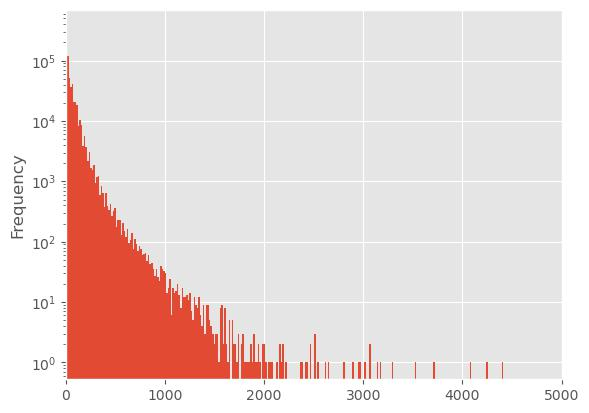

% of transfers longer than 2000 hours (~83 days): 0.01
% of transfers shorter than 3 h: 15.97


In [35]:
X_train.duration.plot.hist(log = True, bins = 500)
plt.xlim((0,5000))


plt.show()

print('% of transfers longer than 2000 hours (~83 days):',round((X_train.duration > 2000).mean()*100,2))
print('% of transfers shorter than 3 h:',round((X_train.duration < 3).mean()*100,2))      

As we see in the histogram above, the transfer duration has an exponential (nearly double exponential) distribution, with a few transfers that lasted more than 2000 hours. 16% of transfers lasted less than 3 h. These short transfers may not be relevant for our study as it may not be possible to predict future stays on such short stays. The number of prescriptions is probably going to be very close to 0 for such short transfers. Let us see the relationship of transfer duration with prescriptions. NOW BIN DURATION AND PLOT AGAINST PRES_NUMBER

In [17]:
pd.concat([X_train[X_train.duration>2000].drop(columns = ['anchor_age','marital_status','race','gender']),y_train[X_train.duration>2000]],axis = 1).sort_values(by = 'duration', ascending = False)

,subject_id,eventtype,careunit,intime,outtime,dod,hadm_id,admission_type,discharge_location,insurance,...,L,M,N,P,R,S,V,pres_number,duration,event
transfer_id,,,,,,,,,,,,,,,,,,,,,
31268121,10788307,admit,Med/Surg,2137-08-08 13:34:03,2143-08-08 14:51:34,NaT,22075259,SURGICAL SAME DAY ADMISSION,HOME,Other,...,0,0,1,0,1,2,4,15,52585.291944,Medicine
38463070,11025319,transfer,Cardiac Surgery,2128-01-10 12:46:41,2128-11-25 16:31:49,NaT,27523218,DIRECT EMER.,HOME,Other,...,0,2,3,1,0,3,0,36,7683.752222,Trauma
39926715,17293909,admit,Medicine/Cardiology,2129-02-18 15:08:00,2129-09-25 12:03:16,NaT,27092644,DIRECT OBSERVATION,HOME,Other,...,0,0,2,0,1,3,1,10,5252.921111,Home
33279072,12313749,transfer,Medicine,2183-02-21 20:29:20,2183-08-24 13:40:51,NaT,20402425,EU OBSERVATION,ACUTE HOSPITAL,Medicare,...,0,5,51,0,16,11,5,111,4409.191944,Other facility
34536397,19297526,admit,Neurology,2187-10-29 17:11:28,2188-04-23 12:08:37,NaT,25148569,OBSERVATION ADMIT,HOME,Other,...,0,0,3,0,0,0,0,10,4242.952500,Home
38123451,10867608,admit,Hematology/Oncology,2185-03-30 13:00:00,2185-09-16 16:43:05,2186-01-22,20767670,EW EMER.,CHRONIC/LONG TERM ACUTE CARE,Other,...,28,0,57,3,19,58,31,254,4083.718056,Other facility
30460193,18672020,admit,Med/Surg,2174-12-07 00:52:00,2175-05-10 09:24:22,NaT,20801324,EU OBSERVATION,HOME,Medicaid,...,0,0,0,0,2,0,0,5,3704.539444,Home
35237934,11963916,transfer,Surgery/Trauma,2155-09-09 18:06:43,2156-02-03 12:30:13,NaT,23483861,URGENT,AGAINST ADVICE,Other,...,0,0,26,0,2,11,14,58,3522.391667,Against Advice
31950630,16415791,admit,Psychiatry,2162-11-17 00:05:49,2163-04-03 10:44:20,2164-07-13,25735682,DIRECT EMER.,SKILLED NURSING FACILITY,Other,...,0,1,19,0,8,8,3,55,3298.641944,Other facility


It is hard to assert that any of these are mistakes, although the first row at least does look like one. This would be  a surgical same-day admission transfer that lasted for 6 years, coincidentially ending the same day of the year that it started 1 h later. We could correct this, but to be consistent with our decision along our training and test datasets, we will drop any transfer lating more than 1 year (8,760 h).

In [18]:
nachopy.change_all(X_train, y_train, X_test, y_test, lambda x: x>8760, 'duration')

In [23]:
y_train.value_counts()

Home                   147620
Medicine                79892
HOME HEALTH CARE        67241
ED obs                  61750
Other facility          58162
Cardiac                 51451
Discharge               36945
Med/Surg                35574
MICU/SICU               32401
Trauma                  29674
Gyn/Obs/Labor           26440
Neuro                   25591
PACU                    16253
Hematology/Oncology     14746
Med/Surg/GYN            13713
Vascular                13483
Transplant              13163
Died                     7030
Against Advice           3148
HOSPICE                  2775
Name: event, dtype: int64

In [44]:
plotting_df

,duration,pres_number,A,B,C,D,G,H,J,L,M,N,P,R,S,V,event
transfer_id,,,,,,,,,,,,,,,,,
31792339,17.767222,42,0.309524,0.261905,0.285714,0.047619,0.000000,0.071429,0.119048,0.0,0.000000,0.214286,0.0,0.023810,0.095238,0.047619,Transfer
36981908,44.760556,18,0.333333,0.222222,0.222222,0.000000,0.000000,0.055556,0.000000,0.0,0.000000,0.222222,0.0,0.000000,0.000000,0.055556,Discharge
31413159,74.959722,42,0.285714,0.380952,0.333333,0.142857,0.071429,0.000000,0.000000,0.0,0.047619,0.309524,0.0,0.119048,0.119048,0.142857,Transfer
30922143,350.755278,14,0.142857,0.357143,0.500000,0.000000,0.000000,0.000000,0.071429,0.0,0.000000,0.071429,0.0,0.000000,0.000000,0.285714,Transfer
34264259,3.100000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,Transfer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36511416,6.075556,5,0.200000,0.600000,0.200000,0.000000,0.000000,0.000000,0.000000,0.4,0.000000,0.000000,0.0,0.000000,0.200000,0.200000,Discharge
31850019,0.230556,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,Transfer
37436903,214.104167,39,0.538462,0.102564,0.358974,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.051282,0.0,0.025641,0.000000,0.076923,Discharge


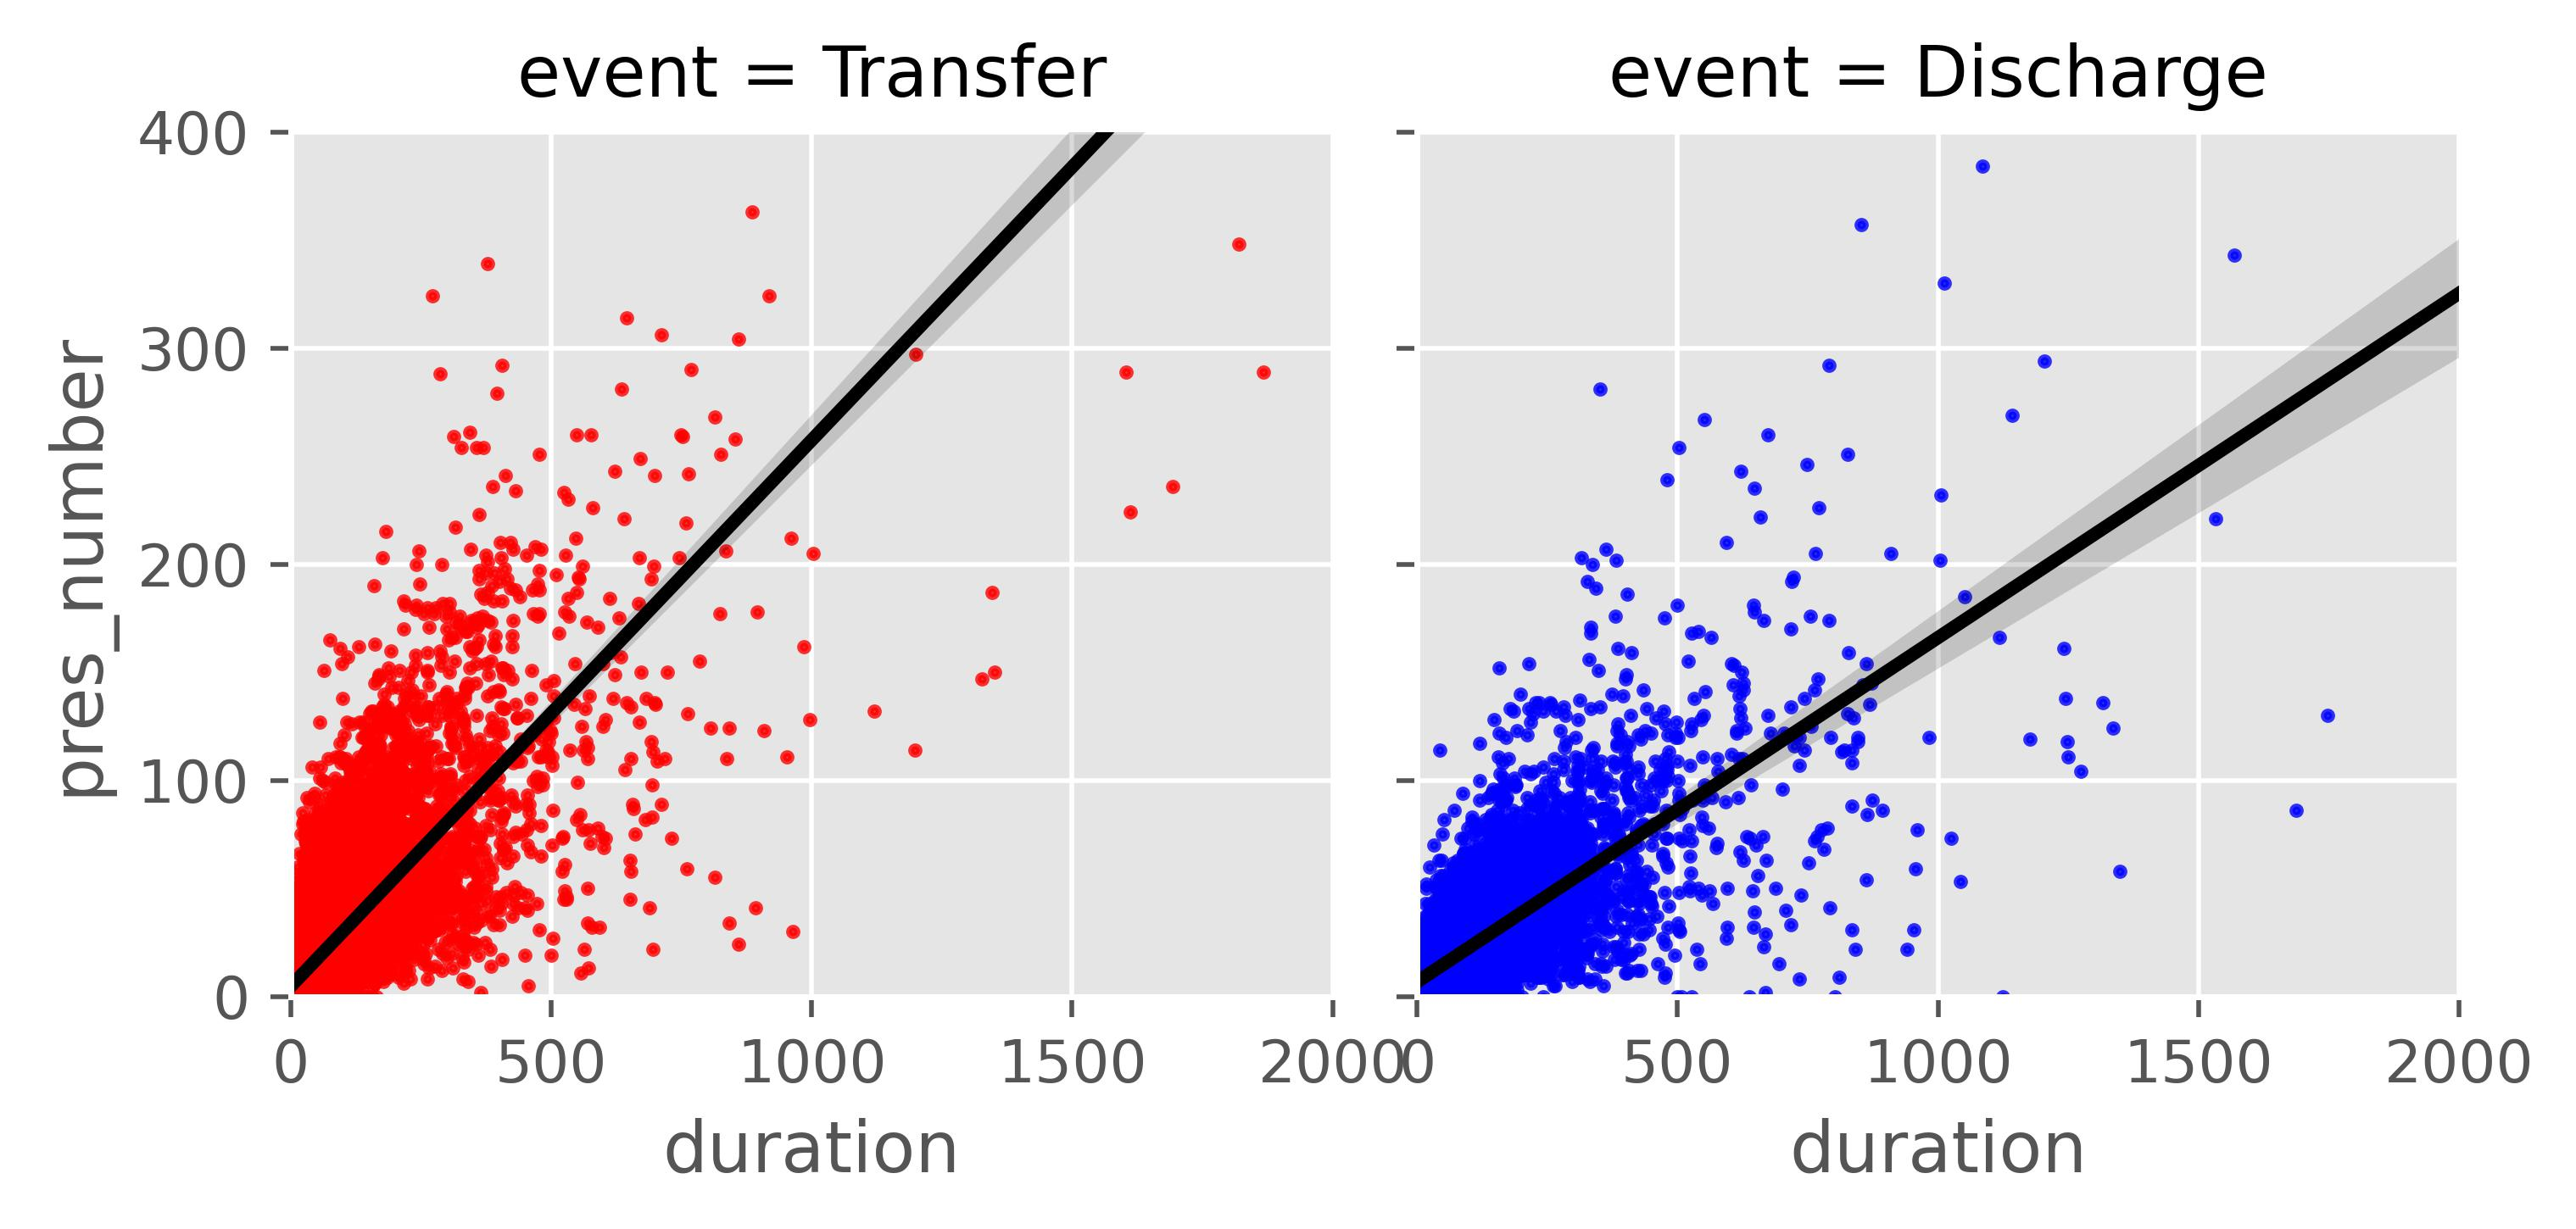

In [67]:
# %matplotlib
%config InlineBackend.figure_formats = ['jpg'] # Setting plots as bit images
cats = list('ABCDGHJLMNPRSV')

working_cols = ['duration','pres_number'] + cats
working_df = pd.concat([X_train[working_cols],y_train],axis = 1)

working_df[cats] = working_df[cats].div(working_df.pres_number, axis = 0).fillna(0)

working_df['event'] = working_df.event.str.replace('/','_')

classes = list(working_df.event.value_counts().index)

plotting_df = working_df.sample(frac = 0.1, random_state = 42)
discharge_bool = plotting_df.event.str.contains('Home|facility|Advice|Discharge|Hospice')
plotting_df.loc[discharge_bool,'event'] = 'Discharge'

plotting_df.loc[~discharge_bool,'event'] = 'Transfer'



g = sns.FacetGrid(plotting_df, hue = 'event', col = 'event', hue_kws = {'color': ['r','b']})
# sns.regplot(data = plotting_df[plotting_df.event == 'Discharge'],
#             x = 'duration', 
#             y = 'pres_number',
#             color = 'blue',
#             scatter = True,
#             scatter_kws = {}
# )
g.map(sns.regplot, 
            'duration', 
            'pres_number',
            scatter = True,
            scatter_kws = {'s':2},
            line_kws = {'color': 'k'}
)
plt.xlim((0,2000))
plt.ylim((0,400))

plt.close(2)
plt.show()


NEED TO LOOK AT DURATION AND PRES_NUMBER INDIVIDUALLY BEFORE.

We see in the graphs above that, although there is a lot of overlap, the number of prescriptions and transfer have different values of length and prescription number. When a transfer ends up in another transfer inside the hospital, the number of prescriptions for the patients is high even at shorter durations. Discharged patients (including all the groups previously included in discharge except the ones that died) have fewer prescriptions and the number of prescriptions increases more slowly as the length of the transfer increases. This is evident in the slopes of the fitted linear regression curves for each subset. Possibly, a good new feature could be the number of prescriptions per duration, as this seems to differentiate the discharge events from the rest of the events quite a lot. Now let us look at the different classes and prescription categories more in depth.

In [21]:
from ipywidgets import widgets, interactive

events_dd = widgets.Dropdown(
    options = ['All'] + classes,
    value = 'All',
    description = 'Class'
)

cats_dd = widgets.Dropdown(
    options = working_cols[1:],
    value = 'pres_number',
    description = 'ATC category'
)


def int_plot(event, cat):
    
    plotting_df = working_df[['duration','event']+[cat]].copy()
    
    if event != 'All':
        plotting_df = plotting_df[plotting_df.event == event]
    
    fig = plt.figure(figsize = (8,5))
    sns.scatterplot(data = plotting_df,\
                         x = 'duration', y = cat, hue = 'event')
    
#     xlim = plotting_df.duration.quantile(0.999)
#     ylim = plotting_df[cat].quantile(0.999)
    plt.legend(loc = (0.8,0))
    
    plt.xlim((0,800))
    
    plt.xlabel('Duration of transfer')
    
    if cat == 'pres_number':
        plt.ylabel('Total number of prescriptions')
        plt.ylim((0,200))
        
    else:
        plt.ylabel(f'Ratio of "{cat}" prescriptions to total')
        plt.ylim((0.,1))
#     button = widgets.Button(description="Save Figure")
#     display(button)
#     button.on_click(save_figure)
    
    fig.show()
    fig.savefig(f'Figures/{cat} for {event}.png',dpi = 300)


interactive(int_plot, event = events_dd, cat = cats_dd)

interactive(children=(Dropdown(description='Class', options=('All', 'Home', 'Medicine', 'HOME HEALTH CARE', 'E…

A | B
- | -
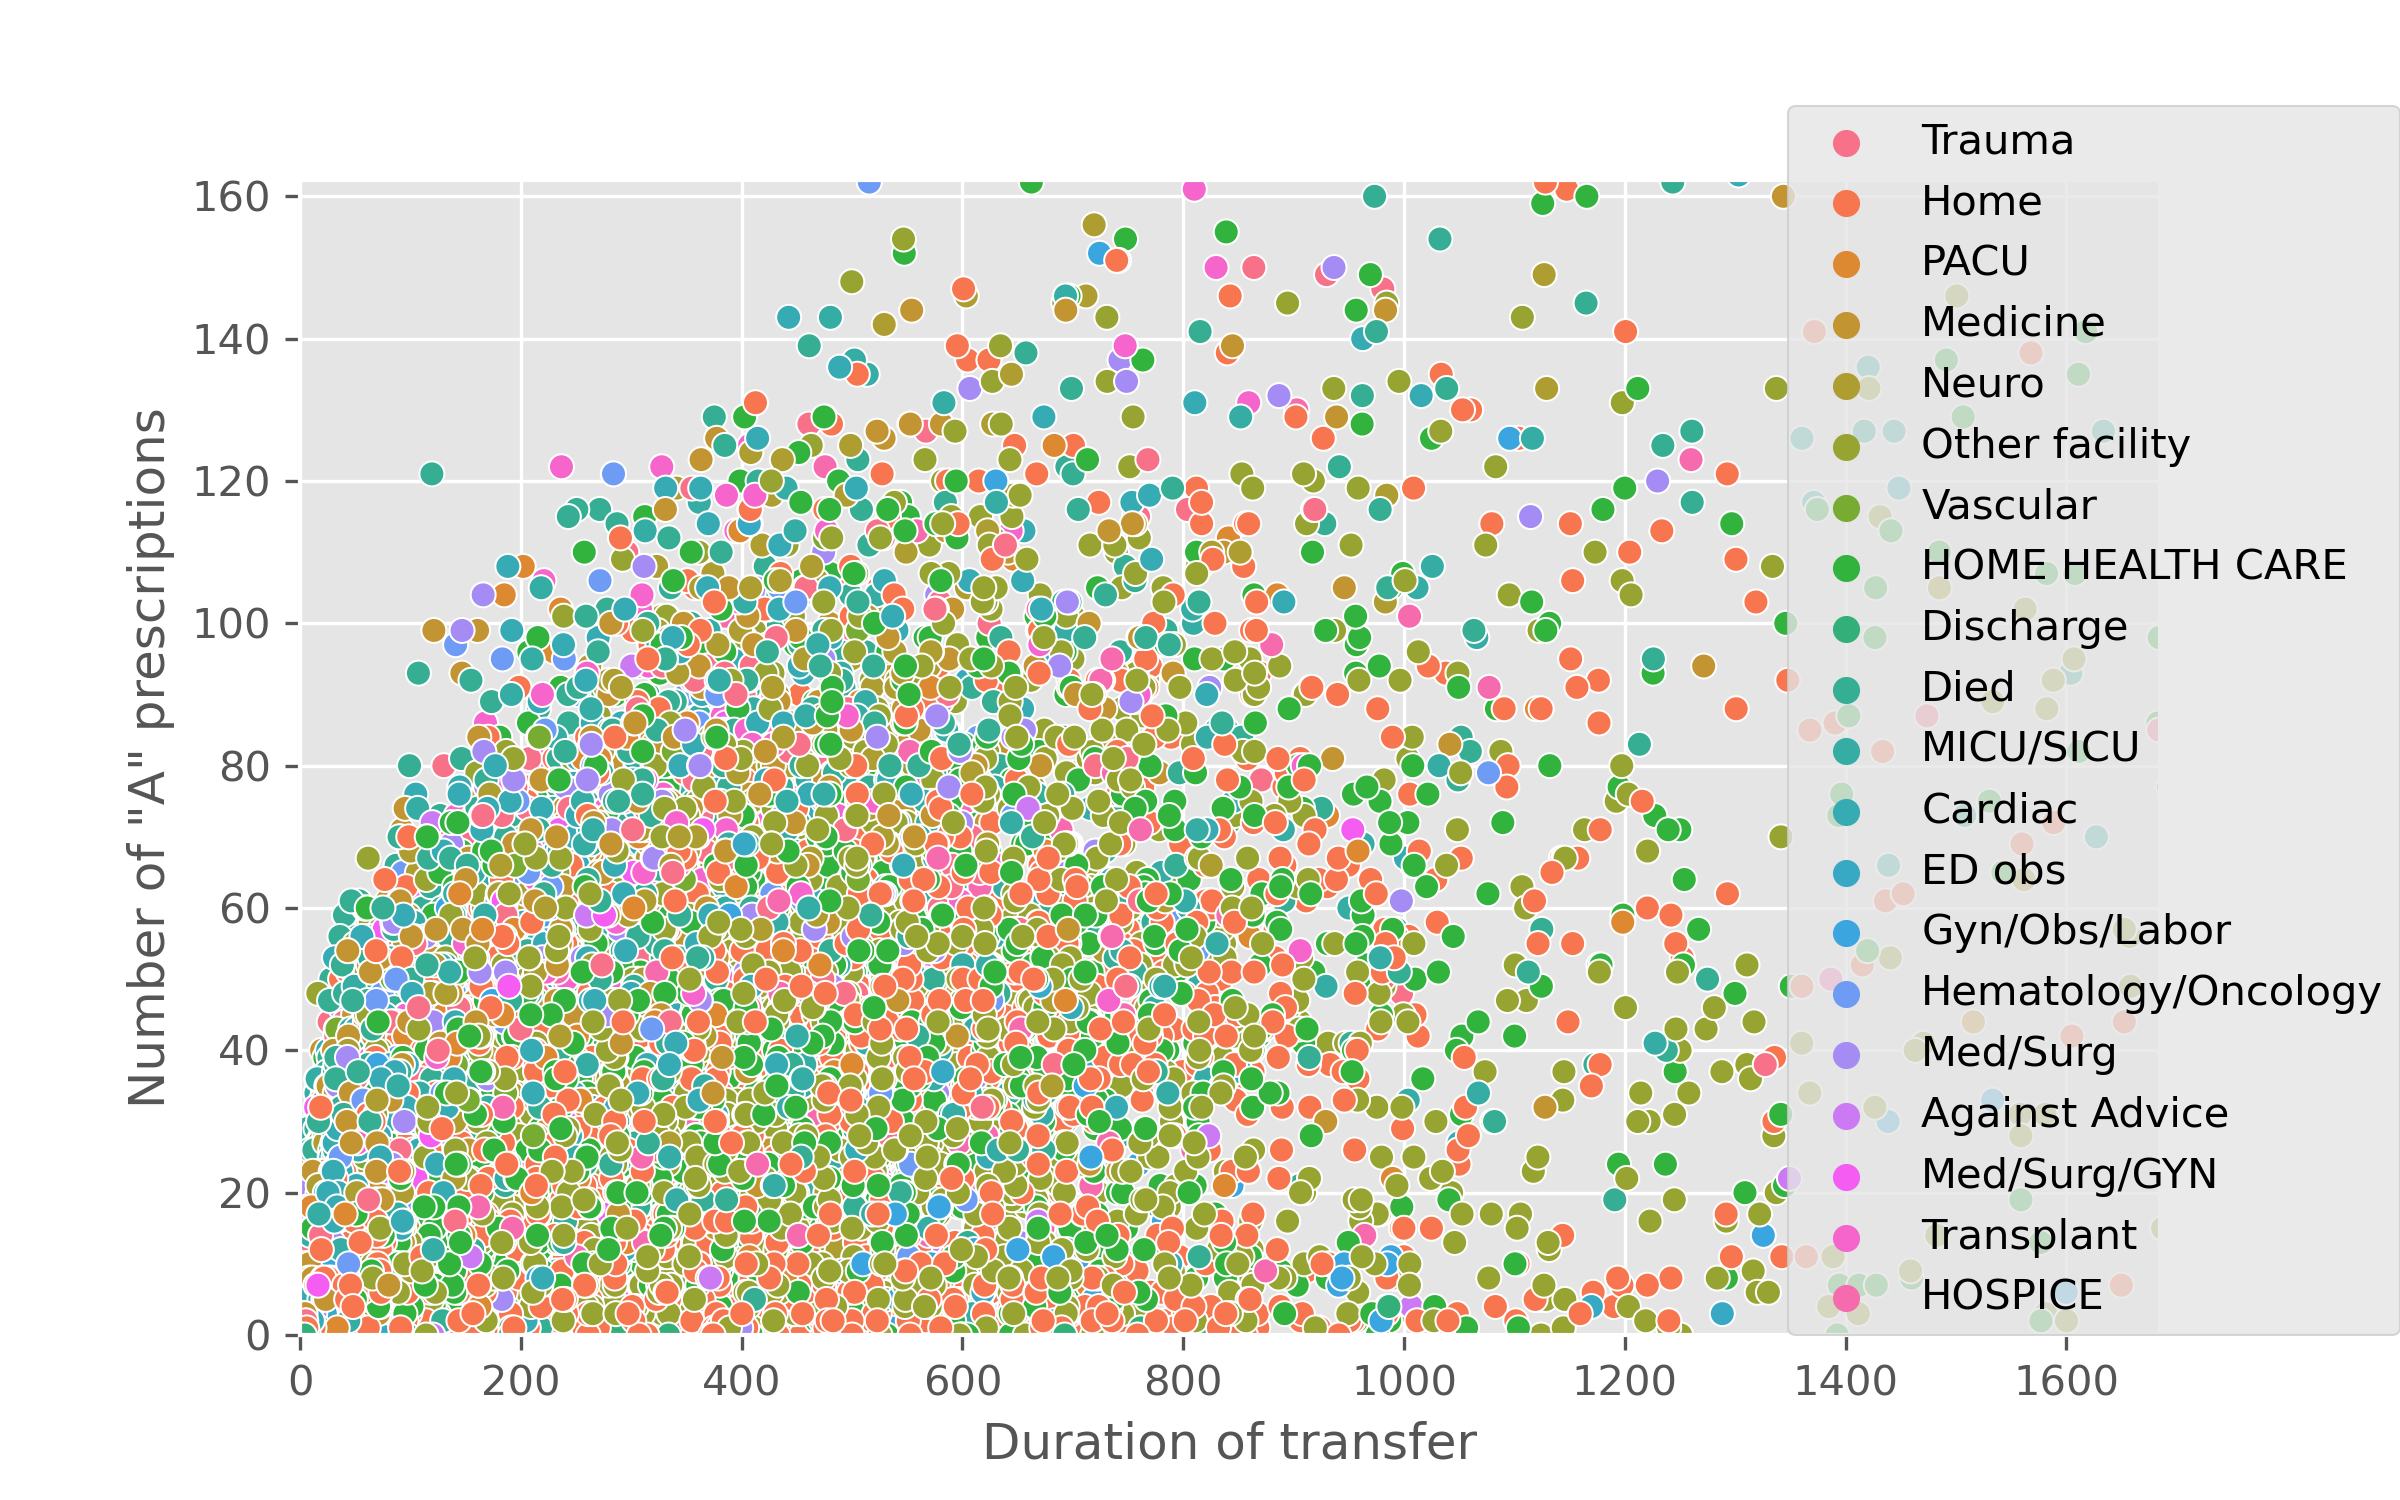

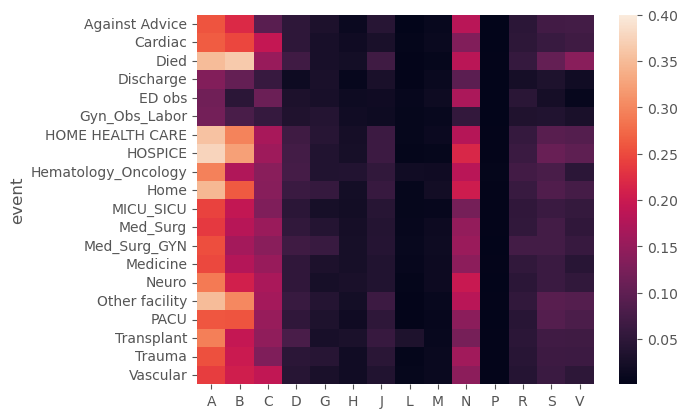

In [115]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt


hmap = sns.heatmap(working_df.groupby('event')[cats].mean(), vmax = 0.4)
plt.show()

In [62]:
from ipywidgets import widgets, interactive
# %matplotlib
# %config InlineBackend.figure_formats = ['png'] # Setting plots as bit images
cats = list('ABCDGHJLMNPRSV')

working_cols = ['duration','pres_number'] + cats
working_df = pd.concat([X_train[working_cols],y_train],axis = 1)
classes = list(y_train.value_counts().index)


events_dd = widgets.Dropdown(
    options = ['All'] + classes,
    value = 'All',
    description = 'Class'
)

cats_dd = widgets.Dropdown(
    options = working_cols[1:],
    value = 'pres_number',
    description = 'ATC category'
)


def int_plot(event, cat):
    
    plotting_df = working_df[['duration','event']+[cat]].copy()
    
    if event != 'All':
        plotting_df = plotting_df[plotting_df.event == event]
    
    fig = plt.figure(figsize = (8,5))
    sns.scatterplot(data = plotting_df,\
                         x = 'duration', y = cat, hue = 'event')
    
    xlim = plotting_df.duration.quantile(0.999)
    ylim = plotting_df[cat].quantile(0.999)
    plt.legend(loc = (0.8,0))
    plt.xlim((0,xlim))
    plt.ylim((0,ylim))
    
    plt.xlabel('Duration of transfer')
    
    if cat == 'pres_number':
        plt.ylabel('Total number of prescriptions')
    else:
        plt.ylabel(f'Number of "{cat}" prescriptions')
    
#     button = widgets.Button(description="Save Figure")
#     display(button)
#     button.on_click(save_figure)
    
    fig.show()
    fig.savefig('Figures/figure.png',dpi = 300)

interactive(int_plot, event = events_dd, cat = cats_dd)



interactive(children=(Dropdown(description='Class', options=('All', 'Home', 'Medicine', 'HOME HEALTH CARE', 'E…

In [52]:
working_df = working_df.join(working_df.loc[working_df.event == event,'pres_number'].rename(event))

In [53]:
working_df

,pres_number,event,Trauma
duration,,,
0.000278,0,Home,NaN
0.000278,0,Medicine,NaN
0.000278,0,Discharge,NaN
0.000278,0,"Gynecology, Obstetrics & Labor",NaN
0.000278,0,Medicine,NaN
...,...,...,...
4083.718056,254,Other facility,NaN
4242.952500,10,Home,NaN
4409.191944,111,Other facility,NaN


In [54]:
working_df = working_df[~working_df.index.duplicated(keep = 'first')]

In [55]:
working_df

,pres_number,event,Trauma
duration,,,
0.000278,0,Home,NaN
0.000556,0,Discharge,NaN
0.000833,0,Home,NaN
0.001111,0,Home,NaN
0.001389,0,Discharge,NaN
...,...,...,...
4083.718056,254,Other facility,NaN
4242.952500,10,Home,NaN
4409.191944,111,Other facility,NaN


In [ ]:
transfers = transfers.join(pd.get_dummies(transfers.gender,drop_first = True,prefix = 'gender_')).drop(columns = 'gender')
transfers = transfers.join(pd.get_dummies(transfers.race)['WHITE'])
transfers = transfers.join(pd.get_dummies(transfers.language)['ENGLISH'])
transfers = transfers.join(pd.get_dummies(transfers.marital_status,drop_first=True)).drop(columns = 'marital_status')
transfers = transfers.join(pd.get_dummies(transfers.insurance,drop_first=True)).drop(columns = 'insurance')
transfers = transfers.join(pd.get_dummies(transfers.admission_type,drop_first=True)).drop(columns = 'admission_type')

In [ ]:
transfers.info()

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(transfers.event)
transfers_y = le.transform(transfers.event)

In [ ]:
fig = plt.figure()
transfers.event.value_counts().plot.barh()
plt.show()
fig.savefig('rowsperclass.svg',bbox_inches='tight')

In [ ]:
sns.heatmap(pres_dfs.groupby('event').mean())

In [ ]:
transfers.info()

In [ ]:
X_cols

In [ ]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(C = 0.1)

LR.fit(X_train,y_train)

print(LR.score(X_train,y_train))
print(LR.score(X_test,y_test))

In [ ]:
np.isnan(y_train).any()

In [ ]:
y_train

In [ ]:
X_train.reset_index(drop = True, inplace = True)

In [ ]:
# Importing functions and classes
from sklearn.preprocessing import MinMaxScaler  
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LogisticRegression 
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV # Grid search tool to try multiple parameters and models
from sklearn.decomposition import PCA

cv = None # Typically 10, ºsomething that would be okay for this dataset as it is large enough, but set as 5 for speed 

# Defining paipeline
# In our pipeline, the data will be normalised before a logistic regression is fitted 
estimators = [('scaler', StandardScaler()),
              ('model',LogisticRegression())] # And logistic regression only (as specified in grid as well)

pipe = Pipeline(estimators)
# Defining parameter grid

n_range = [5,10,15]
C_range = np.logspace(-2,2,num = 5) # Setting range of 9 C values for regularisation from 0.001 to 10,000

param_grid = [
    {
        'scaler':[StandardScaler()], # Normalisations
        'model':[LogisticRegression()], # Model
        'model__C':C_range, # Regularisation parameter
    }
]

# Creating grid using 10 folds (this is the standard and we have enough data so that the training set will not be too small)
grid_logreg = GridSearchCV(pipe, param_grid, cv = cv)
# Fitting grid (or models)
logreg_fitted_grid = grid_logreg.fit(X_train, y_train)
display(logreg_fitted_grid.best_estimator_)

In [ ]:
min(y_train)

In [ ]:
labels = le.inverse_transform(np.arange(18))

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
 

fig1 = ConfusionMatrixDisplay.from_estimator(logreg_fitted_grid, X_test, y_test, normalize = 'true', include_values = False,\
                                      display_labels = labels)
plt.xticks(rotation = 90)
plt.grid(False)
plt.title('t',pad = 10)
plt.show()
fig1.figure_.savefig('confusion.svg',bbox_inches='tight')

In [ ]:
import pickle

In [ ]:
logreg_out = open('../Capstone data/pickles/logreg_caca.pkl','wb')
pickle.dump(logreg_fitted_grid,logreg_out)
logreg_out.close()

In [ ]:
nachopy.roc_n_confusion(logreg_fitted_grid,X_test,y_test)

In [ ]:
transfers_tr = X_train.copy()
transfers_tr['event'] = le.inverse_transform(y_train)

In [ ]:
cat = list('ABCDGHJLMNPRSV')

In [ ]:
cat.append('pres_number')

In [ ]:
cat.append('event')


In [ ]:
pres_dfs = transfers_tr[cat].copy()

In [ ]:
pres_dfs[['A','B']].div(transfers_tr.duration,axis = 0)

In [ ]:
pres_dfs[pres_dfs.columns[:-1]]= pres_dfs[pres_dfs.columns[:-1]].div(transfers_tr.duration,axis = 0)

In [ ]:
fig1 = plt.figure(figsize = (8,6))
sns.heatmap(pres_dfs.groupby('event').mean(),vmax = 1)
plt.title('Patients that ended up in oncology, cardiology and ICU-related\ndepartments had many more prescriptions in previous transfer',pad = 15)
plt.xlabel('Number of prescriptions per transfer')
fig1.savefig('prespertransfervsunit.svg',bbox_inches='tight')

In [ ]:
fig2 = plt.figure(figsize = (10,8))
sns.heatmap(catsperevent.divide(presperevent, axis = 0)*100,cmap='viridis',xticklabels= True)
plt.title('Patients that ended up in different departments were prescribed\ndifferent types of drugs',pad = 15)
plt.xlabel('Number of prescriptions per transfer')
fig2.savefig('drugtypesvcareunit.svg',bbox_inches='tight')

In [ ]:
cat = list('ABCDGHJLMNPRSV')
cat.append('event')
catsperevent = transfers[cat].groupby('event')
catsperevent = catsperevent.sum()/catsperevent.count().sort_index()
presperevent = catsperevent.sum(axis = 1).sort_index(ascending = False)

fig,_ = plt.subplots(2,1,figsize = (8,15))

plt.subplot(2,1,1)
presperevent.sort_values().plot.barh()

plt.subplot(2,1,2)
sns.heatmap(catsperevent.divide(presperevent, axis = 0)*100,cmap='viridis')

plt.show()


In [ ]:
cat = list('ABCDGHJLMNPRSV')
cat.append('event')
catsperevent = transfers[cat].groupby('event')
catsperevent = catsperevent.sum()/catsperevent.count()

Okay, heatmap probably relevant, but I need to normalise the number of prescriptions per event by the duration of the stay

In [ ]:
tran

In [ ]:
poe = pd.read_csv('../Capstone data/MIMIC IV/poe.csv')

In [ ]:
transfers[cat]

In [ ]:
poe.order_type.value_counts(normalize = True)


In [ ]:
cap_utils.display_sbs(['Order subtype value counts'],poe.order_subtype.value_counts(normalize = True))

Probably dropping medications? Could add order sub type and filling the empty values (loads) with the simple order type?

In [ ]:
ed_dupl = edstays.drop(columns = 'stay_id').duplicated()
print(ed_dupl.sum())
edstays = edstays[~ed_dupl]

In [ ]:
edstays.info()

In [ ]:
uniqueid_set = set(transfers.hadm_id.unique())
hadm_len = len(uniqueid_set)
unique_stayid = edstays.stay_id.unique()
stay_len = len(unique_stayid)
set_len = 0
i = 0
while (len(uniqueid_set) > set_len) & (i<stay_len):
    set_len = len(uniqueid_set)
    uniqueid_set.add(unique_stayid[i])
    i +=1
if set_len == hadm_len + stay_len-1:
    print('All good')
else:
    print('caca')

In [ ]:
edstays = edstays[['subject_id','stay_id','intime','outtime']]

In [ ]:
edstays.info()

In [ ]:
edstays['intime'] = pd.to_datetime(edstays.intime,infer_datetime_format=True)
edstays['outtime'] = pd.to_datetime(edstays.outtime,infer_datetime_format=True)

In [ ]:
ed_dupl = edstays.drop(columns = 'stay_id').duplicated()
print(ed_dupl.sum())
edstays = edstays[~ed_dupl]

In [ ]:
transfers = transfers.merge(
                        edstays,
                        left_on = ['subject_id','intime','outtime'], 
                        right_on = ['subject_id','intime','outtime'],
                        how = 'left',
                        copy = False)

In [ ]:
transfers.loc[transfers.hadm_id.isna(),'hadm_id'] = transfers.loc[transfers.hadm_id.isna(),'stay_id']
sum(transfers.hadm_id.isna())

In [ ]:
transfers.careunit.value_counts()

In [ ]:
cat_pres.A.value_counts(normalize = True)*100

In [ ]:
unclass_drugs = cat_pres.drug[cat_pres.A<0].drop_duplicates()
udrugs_gsnvc = cat_pres.gsn[cat_pres.A<0].value_counts()
gsn_udrugs = udrugs_gsnvc[udrugs_gsnvc>1].index.values

In [ ]:
cat.append('gsn')
cat_gsn = cat_pres.loc[cat_pres.gsn.isin(gsn_udrugs),cat].groupby('gsn').max()
cat_gsn = cat_gsn[cat_gsn.A>-1]
cat_gsn

In [ ]:
cat = cat[:-1]
cat_pres[cat] = cat_pres[cat].where(cat_pres[cat]>=0)

In [ ]:
cat_pres.set_index(ind,append = True)

In [ ]:
cat_pres.set_index('gsn', inplace = True)
cat_pres.update(cat_gsn)
cat_pres.set_index(ind)

In [ ]:
cat_pres.head()

In [ ]:
sum(cat_pres.drug.str.contains('polyvalent'))

In [ ]:
cat_pres.gsn[misspelt_drugs_bool].value_counts().describe()

In [ ]:
(5303415+7791711)/len(cat_pres)

In [ ]:
cat

In [ ]:
cat = list('ABCDGHJLMNPRSV')
cat.append('drug')
cat_drug = cat_pres[cat].fillna(0.0001).groupby('formulary_drug_cd',dropna = False).sum()
cat_drug

In [ ]:
atr4_pres.atc4_name.nunique()

The missing values labelled as 0 are now empty strings due to the conversion. There may be other values that are not 0, maybe even some could be in other ndc formats (hyphenated or with less digits). We can find out how many rows have which number of digits.

So all fields that do not have 9-digit numbers have no digits. We can consider all of these as missing values.

More than 12% of ndc fields are missing. Some of the drugs listed here may not have an ndc (Sodium Chloride flush on 2nd row for instance), but others may be mistakes. NDC is specific to product, not to drug (same drug from different companies will have a different code) so filling from the table would not be very accurate. Given that what we need the NDC just to classify our drugs, we will leave these fields blank and will fill the categories instead after NDC-matching.


In [ ]:
prescriptions.ndc[~missing_ndc].drop_duplicates().to_csv('Unique_NDCs.csv')

Let us see if we can fill these missing values by using the other fields in the table. pharmacy_id, gsn, drug and formulary_drug_cd could be used for this.

In [ ]:
prescriptions.formulary_drug_cd.info()

In [ ]:
fdrugna = prescriptions[prescriptions.formulary_drug_cd.isna()]

In [ ]:
def df_filler(x):
    

prescriptions.formulary_drug_cd[prescriptions.drug.isin(fdrugna.drug)].isna()

In [ ]:
prescriptions.gsn.value_counts()

In [ ]:
prescriptions.pharmacy_id.value_counts()

In [ ]:
prescriptions.formulary_drug_cd.value_counts()

In [ ]:
prescriptions.formulary_drug_cd.info()

In [ ]:
prescriptions.drug = prescriptions.drug.str.lower()
prescriptions.drug.value_counts().describe()

In [ ]:
ndc_bool = prescriptions.ndc!=u'' & prescriptions 
print(sum(ndc_bool))
print(sum(~ndc_bool))

In [ ]:
elswhr_bool = prescriptions.loc[~ndc_bool,'drug'].isin(prescriptions.loc[ndc_bool,'drug'])
print(round(sum(elswhr_bool)/sum(~ndc_bool)*100,2))

In [ ]:
prescriptions.loc[elswhr_bool,'ndc'] = prescriptions.loc[ndc_bool*prescriptions.,'ndc']

In [ ]:
prescriptions.ndc.nunique()

In [ ]:
import numpy as np

In [ ]:
medication = pd.read_json(r'C:\Users\Nacho\Downloads\Medication.ndjson', lines = True)

In [ ]:
medication.shape

In [ ]:
prescriptions.ndc.head()

In [ ]:
ndc_desc = pd.read_csv("G:\My Drive\Brainstation\Capstone project\product.csv",usecols = ['PRODUCTNDC','NONPROPRIETARYNAME','PHARM_CLASSES'])

In [ ]:
ndc_desc = ndc_desc.loc[~ndc_desc.PHARM_CLASSES.isna()].reset_index(drop = True)

In [ ]:
ndc_desc.head()

In [ ]:
def sht2nineNDC(x):
    x = x.split('-')
    x = x[0].zfill(5) + x[1].zfill(4)
    
    return x
    

ndc_desc.PRODUCTNDC = ndc_desc.PRODUCTNDC.apply(sht2nineNDC)

In [ ]:
ndc_desc.PRODUCTNDC.head()

In [ ]:
classpername = ndc_desc[['NONPROPRIETARYNAME','PHARM_CLASSES']].groupby('NONPROPRIETARYNAME').nunique()

In [ ]:
classperndc = ndc_desc[['PRODUCTNDC','PHARM_CLASSES']].groupby('PRODUCTNDC').nunique()

In [ ]:
classpername.value_counts()

In [ ]:
classperndc.value_counts()

In [ ]:
np.mean(prescriptions.ndc.isna())*100

In [ ]:
prescriptions.loc[prescriptions.ndc.isna()].head(10)

In [ ]:
ndc_desc.rename(columns = {'PRODUCTNDC' : 'ndc'},inplace = True)

In [ ]:
presfinal = pd.merge(prescriptions,ndc_desc, how = 'left',on = 'ndc')

In [ ]:
np.mean(presfinal.PHARM_CLASSES.isna())

In [ ]:
np.mean(presfinal.NONPROPRIETARYNAME.isna())

In [ ]:
presfinal[['ndc','drug','NONPROPRIETARYNAME','PHARM_CLASSES']]

In [ ]:
presfinal.hadm_id.nunique()

In [ ]:
len(presfinal.PHARM_CLASSES.isna())-sum(presfinal.PHARM_CLASSES.isna())

In [ ]:
classperhadm = presfinal[['PHARM_CLASSES','hadm_id']].groupby('hadm_id').nunique()
classperhadm.describe()

In [ ]:
classperhadm.loc[classperhadm.PHARM_CLASSES == 0].count()

In [ ]:
prescriptions.ndc.apply(lambda x: str(x)[:-2].zfill(9))

In [ ]:
print(ndc_desc.NONPROPRIETARYNAME.nunique())
print(ndc_desc_clean.NONPROPRIETARYNAME.nunique())

In [ ]:
ndc_desc.shape

In [ ]:
ndc_desc.PRODUCTNDC.apply(lambda x: int(x.replace('-','')))

In [ ]:
ndc_desc.PHARM_CLASSES.value_counts

In [ ]:
poe = pd.read_csv('MIMIC IV ED/poe.csv')

In [ ]:
poe.order_status.value_counts(normalize = True)

In [ ]:
poe.loc[poe.order_type == 'Lab'].order_subtype.value_counts()

In [ ]:
poe.order_type.value_counts()

In [ ]:
admissions = pd.read_csv('MIMIC IV ED/admissions.csv')

In [ ]:
admissions.race.value_counts(normalize = True)

In [ ]:
sum(admissions.admission_location.isna())

In [ ]:
admissions.admission_location.value_counts(normalize = True)

In [ ]:
transfers = pd.read_csv('MIMIC IV ED/transfers.csv')

In [ ]:
sum(transfers.eventtype == 'discharge')

In [ ]:
transfers.careunit.value_counts(normalize = True)

In [ ]:
transfers.careunit.unique()

In [ ]:
transfers[['intime','outtime']] = pd.to_datetime(transfers[['intime', 'outtime']])

In [ ]:
transfers.info(show_counts = True)

In [ ]:
bool_outs

In [ ]:
transfers.describe()

In [ ]:
bool_discharge = transfers.eventtype=='discharge'
bool_carenan = transfers.careunit.isna()
bool_outtime = transfers.outtime.isna()

In [ ]:
print(all(bool_discharge == bool_carenan))
print(all(bool_discharge == bool_outtime))


In [ ]:
transfers.head()

In [ ]:
services = pd.read_csv('MIMIC IV ED/services.csv')

In [ ]:
services.shape

In [ ]:
services.head()

In [ ]:
services.prev_service.value_counts()

In [ ]:
transfers.eventtype.value_counts()

In [ ]:
transfers.

In [ ]:
emar = pd.read_csv('MIMIC IV/emar.csv')

In [ ]:
emar.medication.nunique()

In [ ]:
emar.head()

In [ ]:
transfers.careunit.value_counts()

In [ ]:
print('Number of patients:',transfers['subject_id'].nunique())
print('Number of transfers (and rows number):',transfers['transfer_id'].nunique())
print('Number of stays:',transfers['hadm_id'].nunique())
print('Number of departments:',transfers['careunit'].nunique())

In [ ]:
sum(transfers['careunit'].isna())

In [ ]:
print('Number of departments:',transfers['careunit'].unique())

In [ ]:
admissions = pd.read_csv('MIMIC IV ED/admissions.csv')

In [ ]:
pd.to_datetime(admissions.admittime,infer_datetime_format = True).describe(datetime_is_numeric = True)

In [ ]:
admissions.discharge_location.unique()

In [ ]:
admissions.head()

In [ ]:
len(admissions)

In [ ]:
print('Number of patients:',admissions['subject_id'].nunique())
print('Number of transfers (and length of rows):',admissions['transfer_id'].nunique())
print('Number of stays:',transfers['hadm_id'].nunique())
print('Number of departments:',transfers['careunit'].nunique())

In [ ]:
edstays['disposition'].value_counts()

In [ ]:
diagnosis.icd_version.value_counts()

In [ ]:
diagnosis['icd_title'].value_counts().head()

In [ ]:
print('\033[1m' + 'diagnosis')
display(diagnosis.head())
display(diagnosis.info())
print('\033[1m' + 'edstays')
display(edstays.head())
display(diagnosis.info())
print('\033[1m' + 'medrecon')
display(medrecon.head())
display(medrecon.info())
print('\033[1m' + 'pyxis')
display(pyxis.head())
display(pyxis.info())
print('\033[1m' + 'triage')
display(triage.head())
display(triage.info())
print('\033[1m' + 'vitalsign')
display(vitalsign.head())
display(vitalsign.info())